<a href="https://colab.research.google.com/github/dgambone3/CSC6740_Data_Mining_Project/blob/main/DM_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils import resample

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/DM_Project/fetal_health.csv')
feat = data[['baseline value', 
              'accelerations', 
              'fetal_movement',
              'uterine_contractions', 
              'light_decelerations', 
              'severe_decelerations',
              'prolongued_decelerations', 
              'abnormal_short_term_variability',
              'mean_value_of_short_term_variability',
              'mean_value_of_long_term_variability',
              'percentage_of_time_with_abnormal_long_term_variability',
              'fetal_health']]
feat = feat.rename(columns={'percentage_of_time_with_abnormal_long_term_variability':'percent_time_abnormal_long_variability'})
print(feat.columns)


Index(['baseline value', 'accelerations', 'fetal_movement',
       'uterine_contractions', 'light_decelerations', 'severe_decelerations',
       'prolongued_decelerations', 'abnormal_short_term_variability',
       'mean_value_of_short_term_variability',
       'mean_value_of_long_term_variability',
       'percent_time_abnormal_long_variability', 'fetal_health'],
      dtype='object')


## LOAD AND VIEW DATA


In [ ]:
# print('shape: ', data.shape)
# print('cols: ', data.columns)
X = feat[['baseline value', 
              'accelerations', 
              'fetal_movement',
              'uterine_contractions', 
              'light_decelerations', 
              'severe_decelerations',
              'prolongued_decelerations', 
              'abnormal_short_term_variability',
              'mean_value_of_short_term_variability',
              'mean_value_of_long_term_variability',
              'percent_time_abnormal_long_variability']]
y = feat[['fetal_health']]
# print('\nClassifier Counts')
# print(data['fetal_health'].value_counts())
# data.head()


In [ ]:
feat.describe().T

,count,mean,std,min,25%,50%,75%,max
baseline value,2126.0,133.303857,9.840844,106.0,126.000,133.000,140.000,160.000
accelerations,2126.0,0.003178,0.003866,0.0,0.000,0.002,0.006,0.019
fetal_movement,2126.0,0.009481,0.046666,0.0,0.000,0.000,0.003,0.481
uterine_contractions,2126.0,0.004366,0.002946,0.0,0.002,0.004,0.007,0.015
light_decelerations,2126.0,0.001889,0.002960,0.0,0.000,0.000,0.003,0.015
severe_decelerations,2126.0,0.000003,0.000057,0.0,0.000,0.000,0.000,0.001
prolongued_decelerations,2126.0,0.000159,0.000590,0.0,0.000,0.000,0.000,0.005
abnormal_short_term_variability,2126.0,46.990122,17.192814,12.0,32.000,49.000,61.000,87.000
mean_value_of_short_term_variability,2126.0,1.332785,0.883241,0.2,0.700,1.200,1.700,7.000
mean_value_of_long_term_variability,2126.0,8.187629,5.628247,0.0,4.600,7.400,10.800,50.700


In [ ]:
feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 12 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   baseline value                          2126 non-null   float64
 1   accelerations                           2126 non-null   float64
 2   fetal_movement                          2126 non-null   float64
 3   uterine_contractions                    2126 non-null   float64
 4   light_decelerations                     2126 non-null   float64
 5   severe_decelerations                    2126 non-null   float64
 6   prolongued_decelerations                2126 non-null   float64
 7   abnormal_short_term_variability         2126 non-null   float64
 8   mean_value_of_short_term_variability    2126 non-null   float64
 9   mean_value_of_long_term_variability     2126 non-null   float64
 10  percent_time_abnormal_long_variability  2126 non-null   floa

# EXPLORATORY DATA ANALYSIS


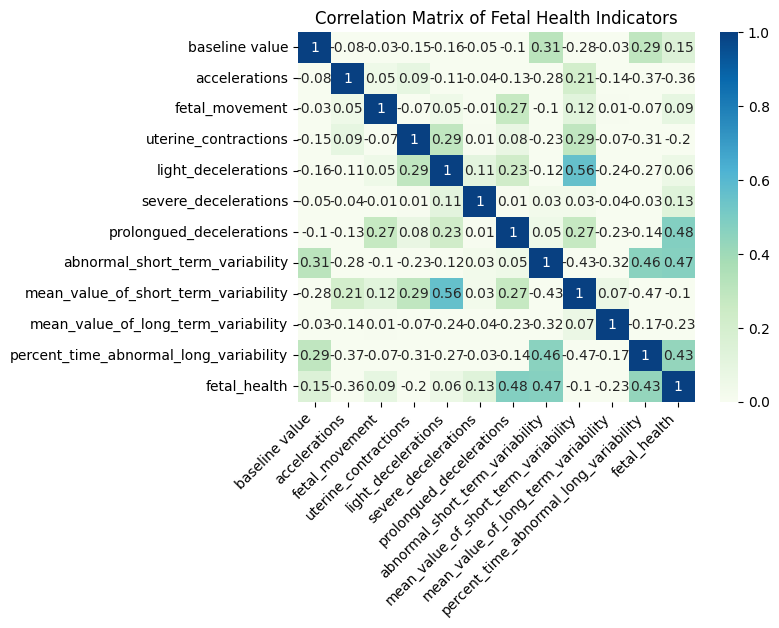

In [ ]:
corr = round(feat.corr(), 2)
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, vmin=0, vmax=1, annot=True, cmap='GnBu')

plt.title('Correlation Matrix of Fetal Health Indicators')
plt.xticks(ha='right', rotation=45)
plt.show()

In [ ]:
# sns.pairplot(feat, hue='fetal_health', kind='scatter', palette='GnBu')
# plt.xticks(ha='right', rotation=45)
# plt.show()

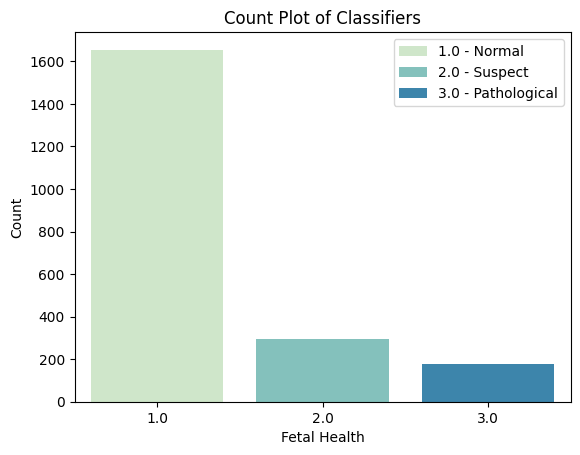

In [ ]:
### CLASSIFIER ANALYSIS ###
labels = ['1.0 - Normal', '2.0 - Suspect', '3.0 - Pathological']
sns.countplot(data, x='fetal_health', palette='GnBu', label=labels)
plt.title('Count Plot of Classifiers')
plt.xlabel('Fetal Health')
plt.ylabel('Count')
plt.legend()
plt.show()

# PREPROCESSING

In [ ]:
### SCALE DATA
sc = StandardScaler().set_output(transform='pandas')
scaled = sc.fit(X).transform(X)

### Principal Component Analysis

In [ ]:
pca = PCA()
pca.fit(scaled)
# print()
d = {'Feature':scaled.columns.values, 'PCA Variance Ratio':pca.explained_variance_ratio_}
pca_info = pd.DataFrame(data=d)
l=[]

for z in range(1, len(pca_info['PCA Variance Ratio']) + 1):
  l.append(sum(pca_info['PCA Variance Ratio'].iloc[:z]))

pca_info['Sum PCA Variance'] = l
display(pca_info)

,Feature,PCA Variance Ratio,Sum PCA Variance
0,baseline value,0.250640,0.250640
1,accelerations,0.148219,0.398859
2,fetal_movement,0.107775,0.506633
3,uterine_contractions,0.102701,0.609334
4,light_decelerations,0.089323,0.698657
5,severe_decelerations,0.076052,0.774709
6,prolongued_decelerations,0.066112,0.840821
7,abnormal_short_term_variability,0.059541,0.900362
8,mean_value_of_short_term_variability,0.043945,0.944307
9,mean_value_of_long_term_variability,0.036622,0.980929


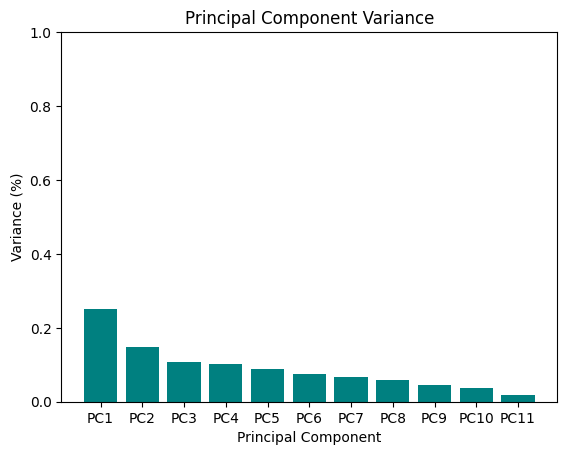

In [ ]:
trained_pca = pca.transform(scaled)
var_ratio = pca_info['PCA Variance Ratio']

x=range(0, len(var_ratio))
plt.bar(x, var_ratio, color='teal')
plt.ylabel('Variance (%)')
plt.xlabel('Principal Component')
plt.xticks(x, ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11'])
plt.ylim([0,1])
plt.title('Principal Component Variance')
plt.show()

### Outlier Detection

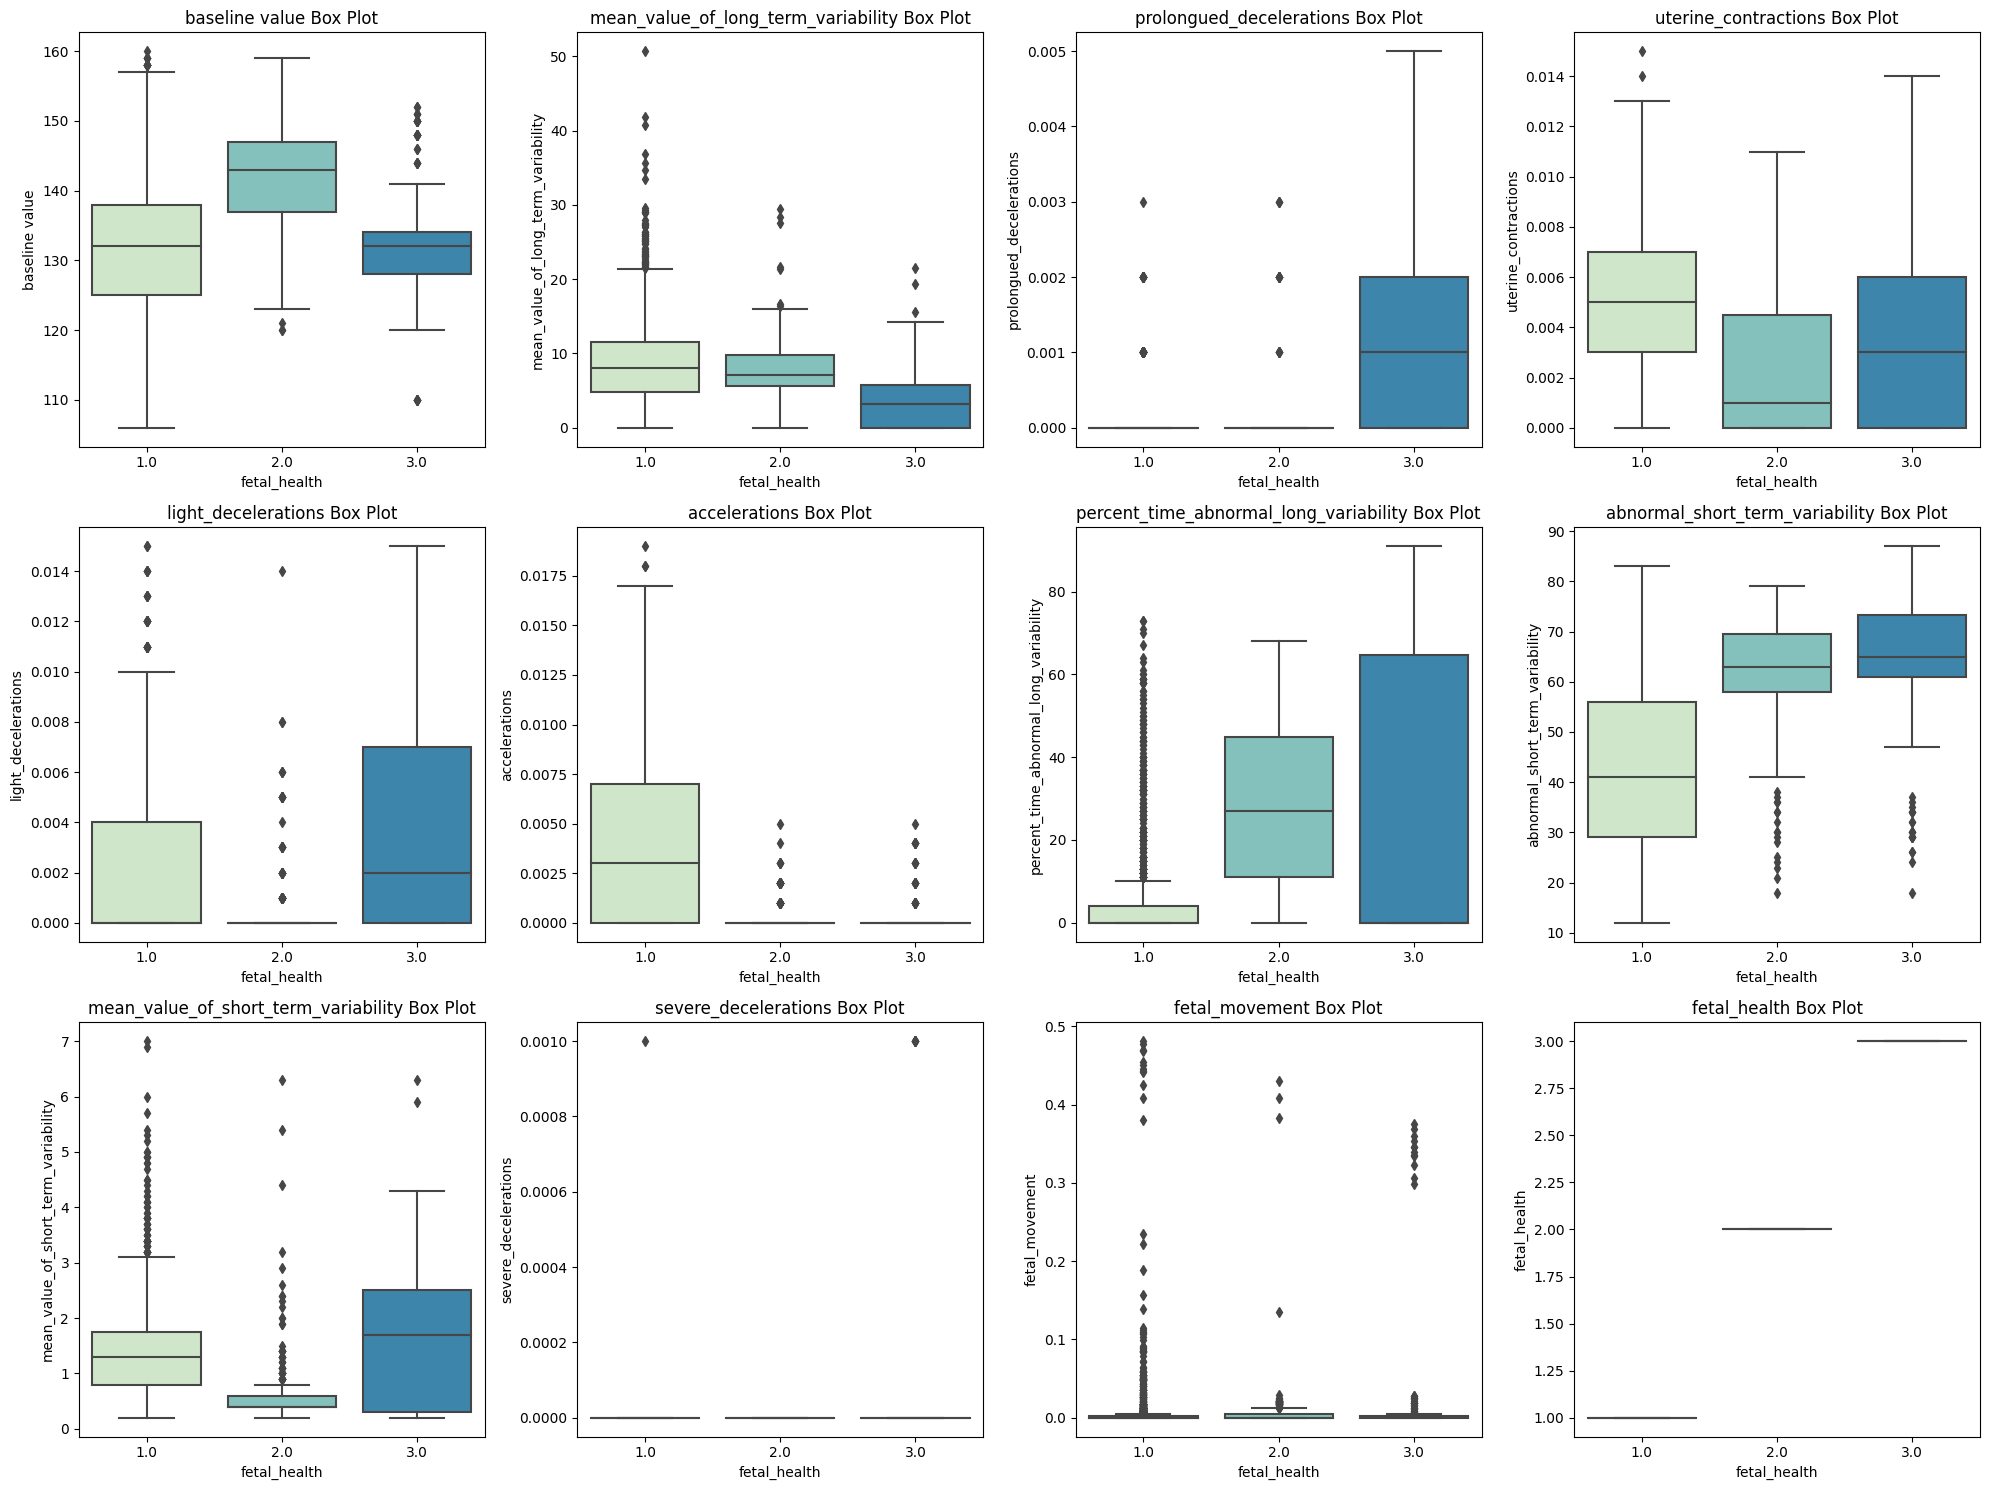

In [ ]:
fig = plt.figure(figsize=(20,15))
axes = fig.subplots(3,4)
i = 0
j = 0
for col in feat[:-2]:
  sns.boxplot(x=feat['fetal_health'], 
              y = feat[col], 
              data=feat, 
              ax=axes[i,j], 
              palette='GnBu')
  # plt.xlabel('Fetal Health')
  axes[i,j].set_title(f'{col} Box Plot')
  i+=1
  j+=1
  if j == 4: j=0
  if i == 3: i=0
fig.tight_layout()
plt.show()

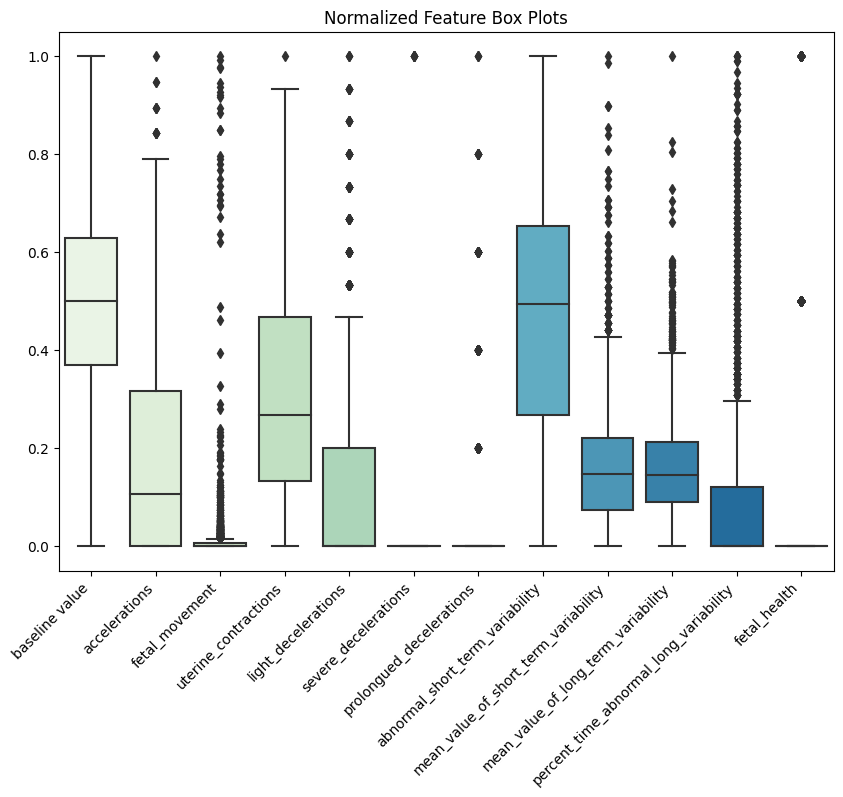

In [ ]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler(feature_range=(0,1)).set_output(transform='pandas')
range_scaled = minmax.fit_transform(feat)
fig = plt.figure(figsize=(10,7))
sns.boxplot(range_scaled,
            palette='GnBu')
plt.title('Normalized Feature Box Plots')
plt.xticks(ha='right',rotation=45)
plt.show()

# Model Selection

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.tree import plot_tree
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
from sklearn.calibration import CalibratedClassifierCV

In [ ]:
sc = StandardScaler().set_output(transform='pandas')
X_temp = feat.iloc[:, :-1]
X = sc.fit(X_temp).transform(X_temp)
y = feat.iloc[:, -1].values
# sss = StratifiedShuffleSplit(n_splits=2, 
#                            train_size=0.8, 
#                            test_size=0.2, 
#                            random_state=1234)

# for i, (train_index, test_index) in enumerate(sss.split(X, y)):
#   X_train = X[train_index]
#   y_train = y[train_index]

#   X_test = X[test_index]
#   y_test = y[test_index]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=1234)

In [ ]:
model_names = ['Decision Tree',
              'Linear Support Vector Machine',
              'Gradient Boost',
              'k-Nearest Neighbors']

dt = DecisionTreeClassifier(criterion='gini',
                            splitter='best',
                            class_weight='balanced')
svc = LinearSVC(penalty='l2',
                loss='squared_hinge',
                C=1.0,
                multi_class='ovr',
                class_weight='balanced',
                dual=False)
gb = GradientBoostingClassifier(loss='log_loss',
                                learning_rate=0.1,
                                criterion='friedman_mse')
knn = KNeighborsClassifier(n_neighbors=5,
                           weights='distance',
                           metric='minkowski',
                           p=2)

models = [dt, svc, gb, knn]

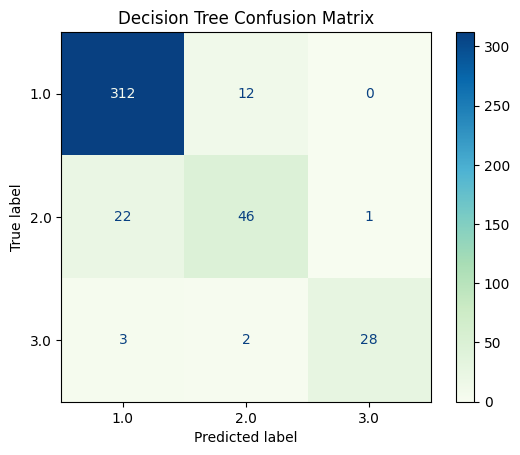

              precision    recall  f1-score   support

         1.0       0.93      0.96      0.94       324
         2.0       0.77      0.67      0.71        69
         3.0       0.97      0.85      0.90        33

    accuracy                           0.91       426
   macro avg       0.89      0.83      0.85       426
weighted avg       0.90      0.91      0.90       426



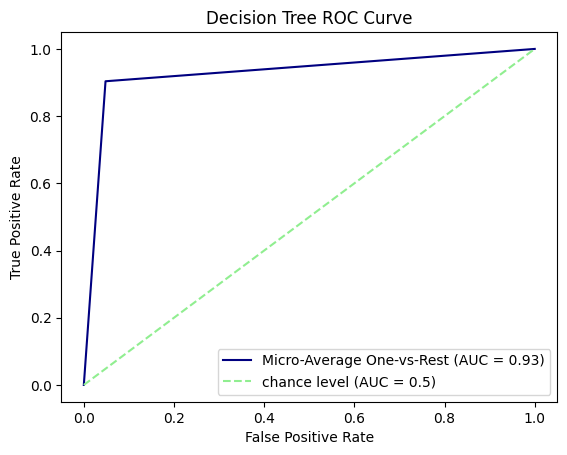

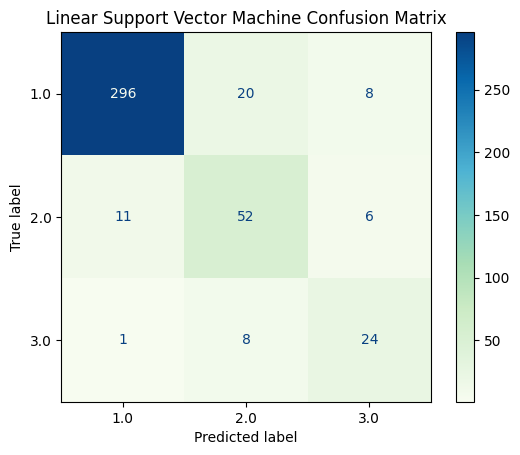

              precision    recall  f1-score   support

         1.0       0.96      0.91      0.94       324
         2.0       0.65      0.75      0.70        69
         3.0       0.63      0.73      0.68        33

    accuracy                           0.87       426
   macro avg       0.75      0.80      0.77       426
weighted avg       0.89      0.87      0.88       426



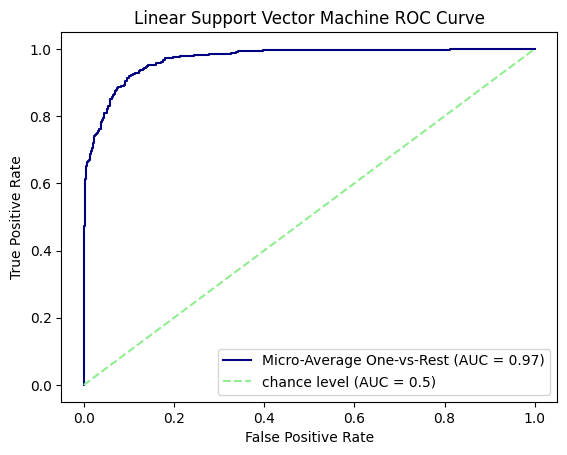

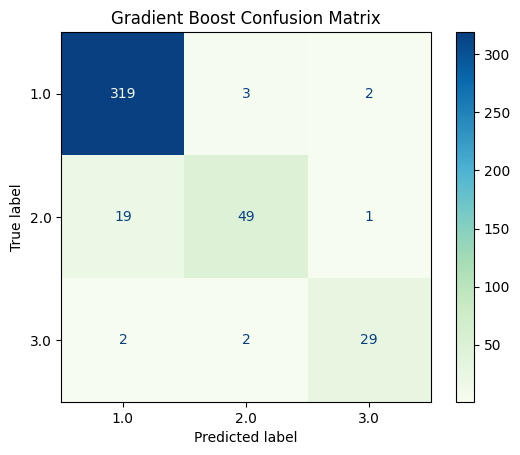

              precision    recall  f1-score   support

         1.0       0.94      0.98      0.96       324
         2.0       0.91      0.71      0.80        69
         3.0       0.91      0.88      0.89        33

    accuracy                           0.93       426
   macro avg       0.92      0.86      0.88       426
weighted avg       0.93      0.93      0.93       426



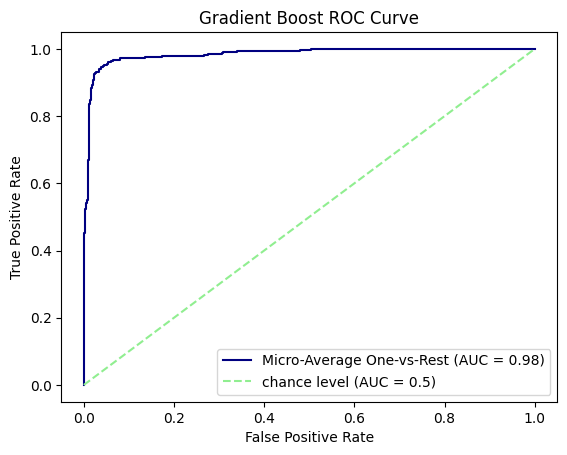

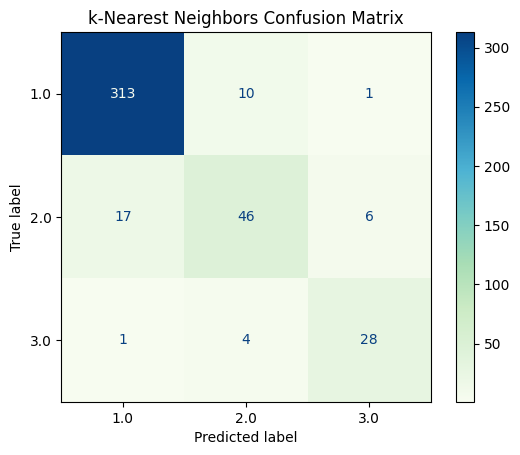

              precision    recall  f1-score   support

         1.0       0.95      0.97      0.96       324
         2.0       0.77      0.67      0.71        69
         3.0       0.80      0.85      0.82        33

    accuracy                           0.91       426
   macro avg       0.84      0.83      0.83       426
weighted avg       0.91      0.91      0.91       426



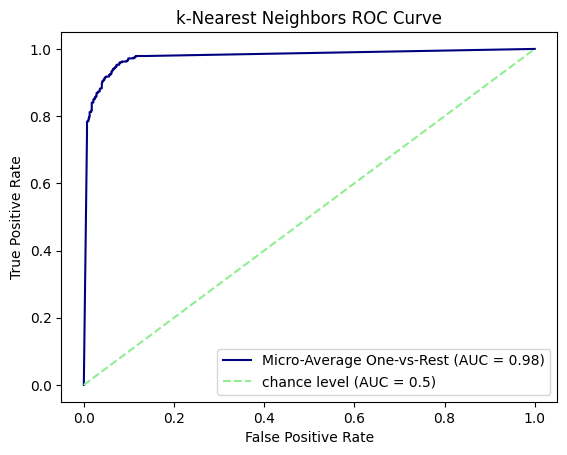

In [ ]:
i=0
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
for model in models:
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  ConfusionMatrixDisplay.from_predictions(y_true=y_test, 
                                          y_pred=pred,
                                          cmap='GnBu')
  plt.title(f'{model_names[i]} Confusion Matrix')
  plt.show()
  
  try:
    y_score = model.fit(X_train, y_train).predict_proba(X_test)

  except:
    m = CalibratedClassifierCV(model) 
    m.fit(X_train, y_train)
    y_score = m.predict_proba(X_test)


  print(classification_report(y_test, pred))
  RocCurveDisplay.from_predictions(y_onehot_test.ravel(),
                                    y_score.ravel(),
                                    name="Micro-Average One-vs-Rest",
                                    color="navy")
  plt.title(f'{model_names[i]} ROC Curve')
  plt.plot([0, 1], [0, 1], label="chance level (AUC = 0.5)", color='lightgreen', linestyle='--')
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  # plt.title("One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)")
  plt.legend()
  plt.show()
  i+=1

In [ ]:
plot_tree(dt)
plt.show()

In [ ]:
svct = LinearSVC(penalty='l2',
                loss='squared_hinge',
                C=1.0,
                multi_class='ovr',
                class_weight='balanced',
                dual=False)
X_train_corr = X_temp[['abnormal_short_term_variability', 'percent_time_abnormal_long_variability']]

svct.fit(X_train_corr, y)

disp = DecisionBoundaryDisplay.from_estimator(svct,
                                              X_train_corr,
                                              response_method="predict",
                                              alpha=0.5,
                                              xlabel='Abnormal Short Term Variability',
                                              ylabel='Percent Time Abnormal Long Variability',
                                              cmap='GnBu')
decision_function = svct.decision_function(X_train_corr)
support_vector_indices = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
support_vectors = X_train_corr.values[support_vector_indices]

scat = plt.scatter(X_train_corr.iloc[:, 0], 
                    X_train_corr.iloc[:, 1], 
                    c=y, 
                    edgecolors="k", 
                    cmap='GnBu')

# DecisionBoundaryDisplay.from_estimator(svct,
#                                         X_train_corr,
#                                         grid_resolution=50,
#                                         plot_method="contour",
#                                         colors="k",
#                                         levels=[-1, 0, 1],
#                                         alpha=0.5,
#                                         linestyles=["--", "-", "--"])

# plt.scatter(support_vectors[:, 0],
#             support_vectors[:, 1],
#             s=100,
#             linewidth=1,
#             facecolors="none",
#             edgecolors="k")
plt.title('Decision Boundaries for Linear Support Vector Machine')

handles, labels = scat.legend_elements()
plt.legend(handles=handles, labels=labels, title="True Class")

plt.show()

. 
 



.



.



.



.



.



.

In [ ]:
# under_df = pd.DataFrame()

# cat1 = feat[feat['fetal_health'] == 1.0]
# cat2 = feat[feat['fetal_health'] == 2.0]
# cat3 = feat[feat['fetal_health'] == 3.0]

# cat1sample = pd.DataFrame(resample(cat1, replace=False, n_samples=len(feat[feat['fetal_health'] == 3.0])))
# cat2sample = pd.DataFrame(resample(cat2, replace=False, n_samples=len(feat[feat['fetal_health'] == 3.0])))

# under_df = pd.concat([cat1sample, cat2sample, cat3]).reset_index(drop=True)

In [ ]:
# corr = round(under_df.corr(), 2)
# mask = np.triu(np.ones_like(corr, dtype=bool))

# sns.heatmap(corr, vmin=0, vmax=1, annot=True, cmap='GnBu')
# plt.title('Correlation Matrix of Fetal Health Indicators - Under sampled')
# plt.show()

In [ ]:
# labels = ['1.0 - Normal', '2.0 - Suspect', '3.0 - Pathological']
# sns.countplot(under_df, x='fetal_health', palette='GnBu', label=labels)
# plt.title('Count Plot of Classifiers - under sample')
# plt.xlabel('Fetal Health')
# plt.ylabel('Count')
# plt.legend()
# plt.show()

In [ ]:
# fig = plt.figure(figsize=(20,15))
# axes = fig.subplots(3,4)
# i = 0
# j = 0
# for col in feat[:-2]:
#   sns.boxplot(x=under_df['fetal_health'], 
#               y = under_df[col], 
#               data=under_df, 
#               ax=axes[i,j], 
#               palette='GnBu')
#   plt.xlabel('Fetal Health')
#   axes[i,j].set_title(f'{col} Box Plot - under sampled')
#   i+=1
#   j+=1
#   if j == 4: j=0
#   if i == 3: i=0
# fig.tight_layout()
# plt.show()

In [ ]:
# minmax = MinMaxScaler(feature_range=(0,1)).set_output(transform='pandas')
# range_scaled = minmax.fit_transform(under_df)
# fig = plt.figure(figsize=(10,7))
# sns.boxplot(range_scaled,
#             palette='GnBu')
# plt.title('Range Normalized Feature Box Plots - under sample')
# plt.xticks(ha='right',rotation=45)
# plt.show()

In [ ]:
# y = data[['fetal_health']].values
# print('y shape: ', y.shape)
# X = data.iloc[:, :-1]
# print('X shape: ', X.shape)